<a href="https://colab.research.google.com/github/kingcodes02/Time-Series-Forcasting/blob/main/06%20-%20Non_Seasonal_ARIMA_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
os.chdir('/content/drive/MyDrive/complete-time-series/7-Non_Seasonal_ARIMA_models')

In [8]:
ls

'3.1 us_airline_carrier_passenger.csv'


In [9]:
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Non Seasonal ARIMA Model
- ARIMA(p,d,q)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#datetime
from datetime import datetime
# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.SARIMAX import ARIMA, ARMA
import statsmodels.api as sm

In [53]:
# warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# load the data
df = pd.read_csv('3.1 us_airline_carrier_passenger.csv')
df.head()

,month,passengers
0,2000-01-01,46492
1,2000-02-01,48526
2,2000-03-01,58764
3,2000-04-01,56033
4,2000-05-01,58201


* train data: 2000-01-01 to 2016-12-01
* test data: 2017-01-01 to 2019-12-01

In [15]:
df.dtypes

month         object
passengers     int64
dtype: object

In [16]:
# change the datetime format
df['month'] = pd.to_datetime(df['month'])

In [17]:
# split: train and test
cut_off = datetime.strptime('2016-12-01', '%Y-%m-%d')
train_df = df[df['month'] <= cut_off]
test_df = df[df['month'] > cut_off]
# set the timeas index
train_df.set_index('month', inplace=True)
test_df.set_index('month', inplace=True)

In [19]:
train_df.tail()

,passengers
month,
2016-08-01,73450
2016-09-01,66477
2016-10-01,69539
2016-11-01,66591
2016-12-01,67983


In [20]:
test_df.head()

,passengers
month,
2017-01-01,62621
2017-02-01,58377
2017-03-01,72962
2017-04-01,70262
2017-05-01,73679


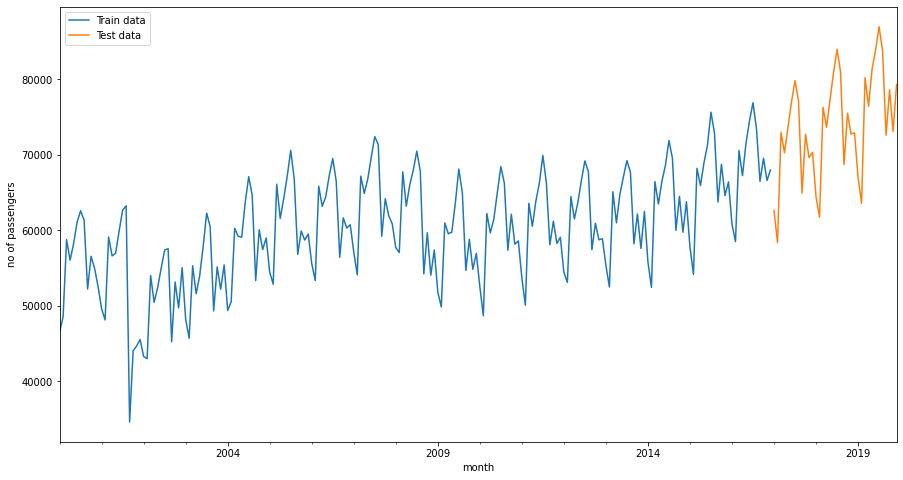

In [23]:
# visualize
fig,ax = plt.subplots(figsize=(15, 8))
train_df.plot(kind='line', ax=ax)
test_df.plot(kind='line', ax=ax)
plt.xlabel('month')
plt.ylabel('no of passengers')
plt.legend(['Train data', 'Test data']);

### ARIMA (p,d,q)

Steps for ARIMA

1. Augumented Dickey-Fuller unitroot test for Stationary
2. If not stationary convert into Stationary
3. Find p,d,q
  - p: AR (auto regressive) order (pacf)
  - d:
  - q: MA (moving average) order (acf)

4. Train ARIMA model
5. Convert the stationary to non-stationary

### Step-1: **Augumented Dickey-Fuller**
- significance level = 5%
  - p-value = 0.025

- Ho: Data is non-stationary (p-value >= 0.025)
- HA: Data is stationary (p-value < 0.025)

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
adfuller(train_df)

(-0.9529124941948438,
 0.7700488660390643,
 13,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 3449.617955746232)

- from the above test, p-value is greater than 0.025, hence with 5% significance the data is non-stationary.
- So, I need to difference to convert data into stationary.

### Step-2: Convert non-stationary data to stationary

In [26]:
stationary_train_df = train_df.diff() # difference
stationary_train_df.dropna(inplace=True) # drop the null values

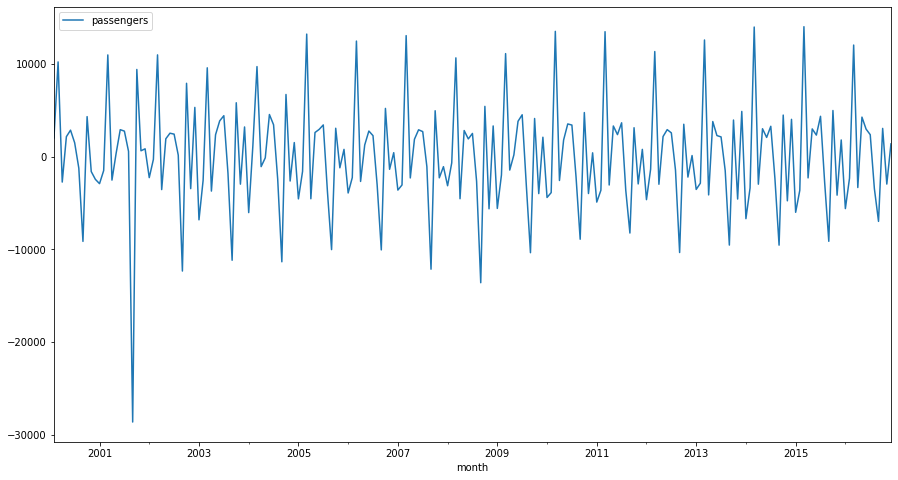

In [29]:
fig,ax = plt.subplots(figsize=(15,8))
stationary_train_df.plot(kind='line', ax=ax);

In [30]:
 # test for stationary
 adfuller(stationary_train_df)

(-3.770003898122382,
 0.0032295638943139375,
 12,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 3430.804868488187)

- From the above results, p-value = 0.003 which is less than 0.025. Hence, p-value falls in critical region therefore the null hypothesis will be rejected and alternate hypothesis will be accepted (data is stationary).

### Step-3:

**Find p,q**

p: AR order(pacf) 
q: MA order(acf)

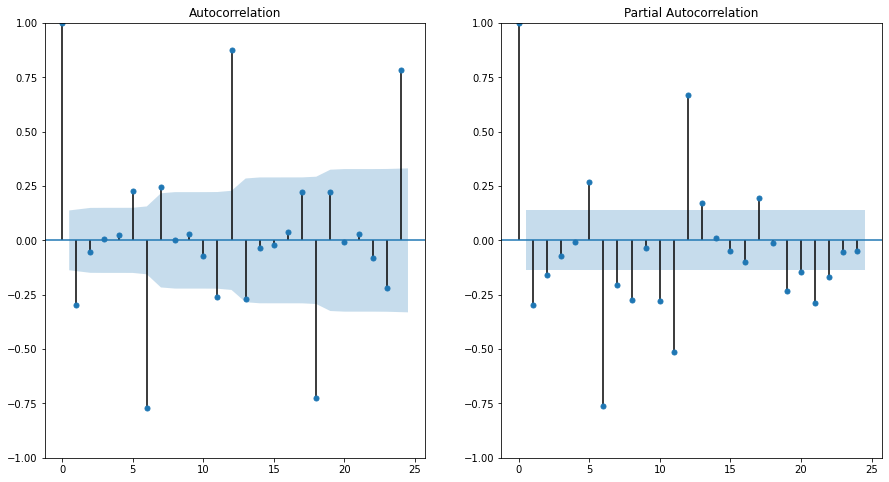

In [34]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

fig = plot_acf(stationary_train_df, ax=ax[0])
fig = plot_pacf(stationary_train_df, ax=ax[1])

p = 6, q = 6

### Step-4: Train ARIMA model

In [87]:
p,d,q = (6, 0, 6)
model_arima = ARIMA(stationary_train_df, order=(p,d,q)).fit()

In [88]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  203
Model:                 ARIMA(6, 0, 6)   Log Likelihood               -1880.930
Date:                Wed, 24 Aug 2022   AIC                           3789.860
Time:                        10:04:40   BIC                           3836.245
Sample:                    02-01-2000   HQIC                          3808.626
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        105.8662    218.659      0.484      0.628    -322.697     534.429
ar.L1         -0.0062      0.024     -0.256      0.798      -0.054       0.041
ar.L2          0.0044      0.030      0.144      0.8

evaluation

In [70]:
model_arima.aic # error

3863.128357798111

In [64]:
from sklearn.metrics import mean_squared_error

In [71]:
fitted_values = model_arima.fittedvalues

In [73]:
mse = mean_squared_error(stationary_train_df, fitted_values)
print('mean sqaure error =', mse)

mean sqaure error = 9429864.633558879


### visualization

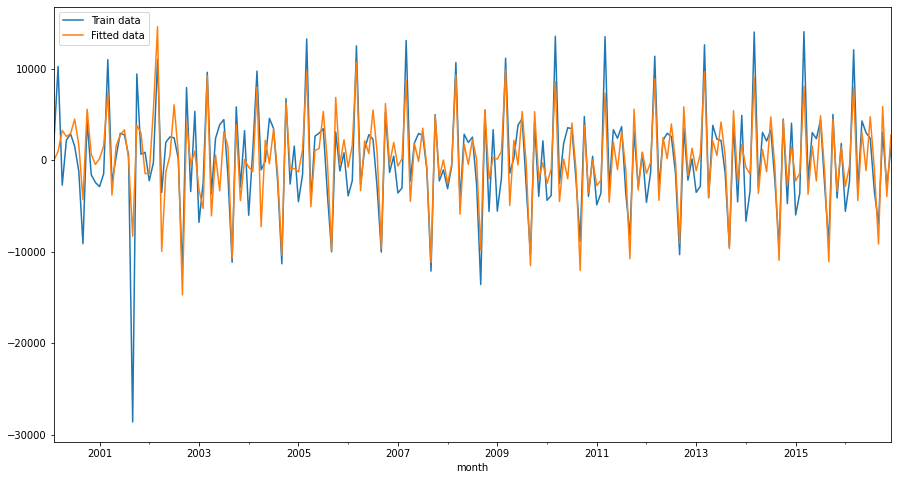

In [76]:
fig,ax = plt.subplots(figsize=(15,8))
stationary_train_df.plot(kind='line', ax=ax)
fitted_values.plot(kind='line', ax=ax)
plt.legend(['Train data', 'Fitted data']);

In [89]:
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2019-12-01', '%Y-%m-%d')
prediction_values_arima = model_arima.predict(start=start_date, end=end_date) # stationary in nature

In [82]:
# last value
train_df.iloc[-1]

passengers    67983
Name: 2016-12-01 00:00:00, dtype: int64

In [99]:
# convert stationary to non stationary
initial_value = 67983
forecasted_value_arima = initial_value + np.cumsum(prediction_values_arima)

In [100]:
len(forecasted_value_arima)

36

In [103]:
# confidence interval
# for_val = model_arima.forecast(steps=36)
confidence_interval = model_arima.forecast(steps=36)[-1]

In [104]:
confidence_interval

909.893762886819

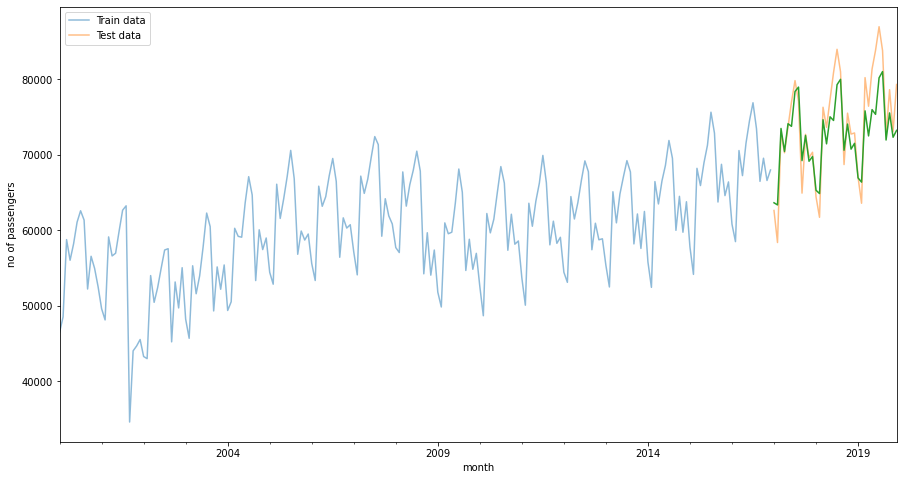

In [92]:
# visualize
fig,ax = plt.subplots(figsize=(15, 8))
train_df.plot(kind='line', ax=ax, alpha=0.5)
test_df.plot(kind='line', ax=ax, alpha=0.5)

forecasted_value_arima.plot(kind='line', ax=ax)
plt.xlabel('month')
plt.ylabel('no of passengers')
plt.legend(['Train data', 'Test data']);